In [112]:
##### FORMATTING AND GRAPHING LIBRARIES #####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns

##### TIMING AND UTILITY LIBRARIES #####
from datetime import datetime
from dateutil.relativedelta import relativedelta 

##### MODELING LIBRARIES #####
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# MAPE function taken from:
# https://www.statology.org/mape-python/
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

### Week-Forward Accuracy

In [20]:
# Import datasets
df_rnn_test = pd.read_csv('../Outputs/RNN_validation_test_preds.csv', index_col = 0, parse_dates = [0])
df_lasso_test = pd.read_csv('../Outputs/LASSO_validation_test_preds.csv', index_col = 0, parse_dates = [0])

In [30]:
# Create dataframe for first-week MAPE scores
df_first_week = pd.DataFrame(columns = ['LASSO','RNN'])

In [41]:
# Loop through all RNN values 
for column in df_rnn_test.drop(columns = ['value','2018-12-31']).columns:
    # Create masks to eliminate null values for each column and limit the data to the first seven days of data
    mask_null_lasso = (df_lasso_test[column].notna())
    mask_week_lasso = (df_lasso_test.index < datetime.strptime(column,'%Y-%m-%d') + relativedelta(days = 7))
    mask_null_rnn = (df_rnn_test[column].notna())
    # The RNN models lose 12 hours of data from the date of the model, so 7.5 days are required to get a full 168 hours
    mask_week_rnn = (df_rnn_test.index < datetime.strptime(column,'%Y-%m-%d') + relativedelta(days = 7.5))

    # Calculate the MAPE for that week and add it to the dataframe
    lasso_mape = mape(df_lasso_test.loc[mask_null_lasso & mask_week_lasso,'value']
                    , df_lasso_test.loc[mask_null_lasso & mask_week_lasso, column])
    df_first_week.at[column,'LASSO'] = lasso_mape
    rnn_mape = mape(df_rnn_test.loc[mask_null_rnn & mask_week_rnn,'value']
                    , df_rnn_test.loc[mask_null_rnn & mask_week_rnn, column])
    df_first_week.at[column,'RNN'] = rnn_mape

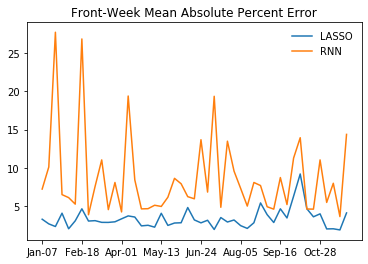

In [109]:
date_x = pd.to_datetime(df_first_week.index).strftime('%b-%d')
plt.plot(date_x, df_first_week['LASSO'])
plt.plot(date_x, df_first_week['RNN'])
plt.xticks(date_x[::6],date_x[::6])
plt.title('Front-Week Mean Absolute Percent Error')
plt.legend(labels = ['LASSO','RNN'], frameon = False);

### Forms of Seasonality

In [227]:
# Import dataset
df_load = pd.read_csv('../PJM_Weekly_Model/PJMLoad_Hourly_ValidationData.csv', index_col = 0, parse_dates = [0])

In [111]:
df_load.head()

,RTO_Load
Date,
2013-07-31 00:00:00,83724.0
2013-07-31 01:00:00,78210.0
2013-07-31 02:00:00,74552.0
2013-07-31 03:00:00,72636.0
2013-07-31 04:00:00,71932.0


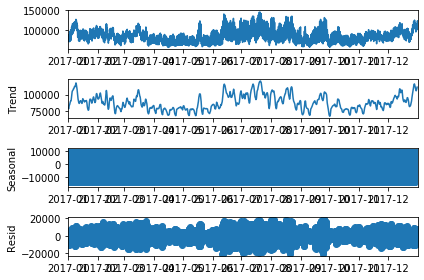

In [115]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(df_load['2017'])

# Plot the decomposed time series.
decomp.plot();

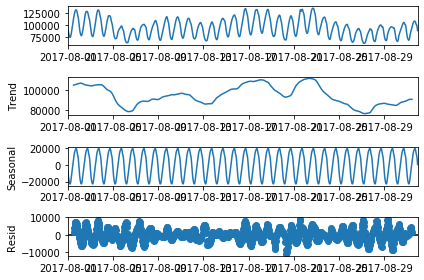

In [119]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(df_load['2017-08'])

# Plot the decomposed time series.
decomp.plot();

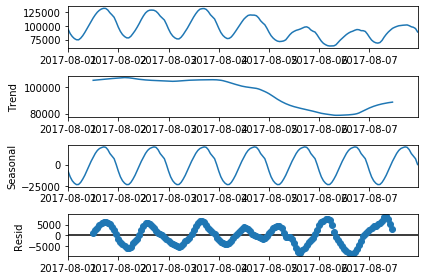

In [122]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(df_load[(df_load.index >= '2017-08-01') & (df_load.index < '2017-08-08')])

# Plot the decomposed time series.
decomp.plot();

In [158]:
# Create mask to limit data to time range with complete data prior to COVID impact
mask_dates = (df_load.index >= '2017-01-01') & (df_load.index < '2020-03-01')

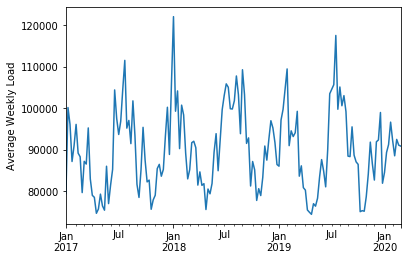

In [173]:
df_load[mask_dates].resample('W').mean().plot(legend = False)
plt.xlabel('')
plt.ylabel('Average Weekly Load');

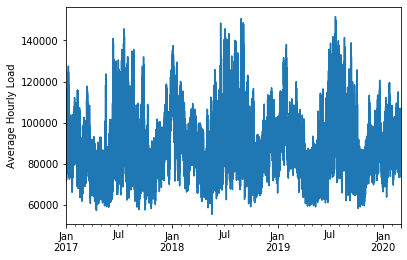

In [175]:
df_load[mask_dates].plot(legend = False)
plt.xlabel('')
plt.ylabel('Average Hourly Load');

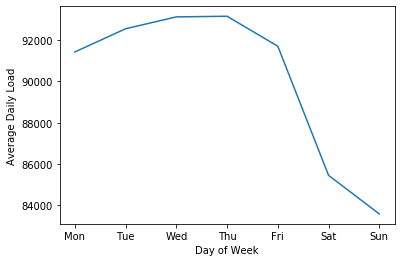

In [164]:
# Weekday assign code taken from:
# https://stackoverflow.com/questions/53306040/pandas-resample-groupby-day-of-week-and-year
df_load.assign(day_of_week = df_load.index.weekday)[mask_dates].groupby(['day_of_week']).mean().plot(legend = False)
plt.xticks(np.arange(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Average Daily Load');

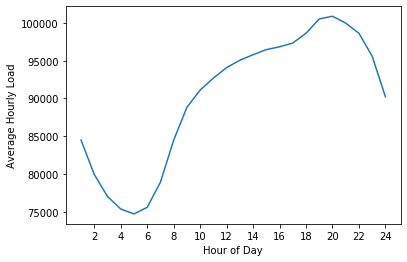

In [188]:
# Weekday assign code taken from:
# https://stackoverflow.com/questions/53306040/pandas-resample-groupby-day-of-week-and-year
df_load.assign(hour = df_load.index.hour + 1)[mask_dates].groupby(['hour']).mean().plot(legend = False)
plt.xticks(np.arange(25)[2::2])
plt.xlabel('Hour of Day')
plt.ylabel('Average Hourly Load');

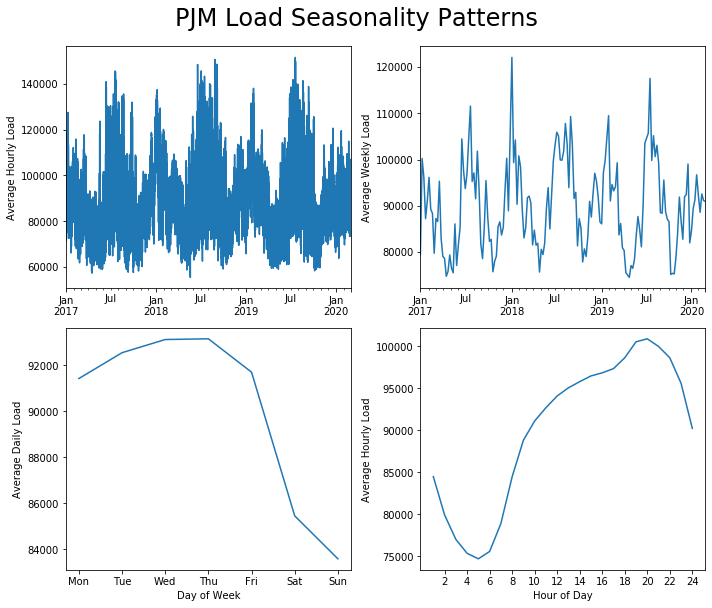

In [225]:
plt.figure(1, figsize = (10,8))
plt.suptitle('PJM Load Seasonality Patterns', y = 1.05, fontsize = 24)

plt.subplot(2,2,1)
df_load[mask_dates].plot(legend = False, ax=plt.gca())
plt.xlabel('')
plt.ylabel('Average Hourly Load')

plt.subplot(2,2,2)
df_load[mask_dates].resample('W').mean().plot(legend = False, ax=plt.gca())
plt.xlabel('')
plt.ylabel('Average Weekly Load')

plt.subplot(2,2,3)
df_load.assign(day_of_week = df_load.index.weekday)[mask_dates].groupby(['day_of_week']).mean().plot(legend = False, ax=plt.gca())
plt.xticks(np.arange(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Average Daily Load')

plt.subplot(2,2,4)
df_load.assign(hour = df_load.index.hour + 1)[mask_dates].groupby(['hour']).mean().plot(legend = False, ax=plt.gca())
plt.xticks(np.arange(25)[2::2])
plt.xlabel('Hour of Day')
plt.ylabel('Average Hourly Load')

plt.tight_layout();

### Weather Relationships

In [258]:
# Import dataset
df_weather = pd.read_csv('../PJM_Weekly_Model/PJMWeatherData_Hourly_ValidationData.csv', index_col = 0, parse_dates = [0])

In [259]:
# Add load data to weather dataframe
df_weather = pd.merge(df_weather, df_load, how = 'left', left_index = True, right_index = True)

In [260]:
# Convert temperature and dew point to fahrenheit from celsius
df_weather['TMP'] = df_weather['TMP'] * 9/5 + 32
df_weather['DEW'] = df_weather['DEW'] * 9/5 + 32

In [276]:
# Winter Weather Parameter
# If Wind Speed <= 10 MPH, set WWP = TMP
df_weather.loc[df_weather['WND'] <=  10,'WWP'] = df_weather['TMP']
# If Wind Speed > 10 MPH, set WWP = TMP - (0.5x(WND-10))
df_weather.loc[df_weather['WND'] > 10,'WWP'] = df_weather['TMP'] - 0.5 * (df_weather['WND'] - 10)

# Temperature Humidity Index
# If Temp < 58, set THI = TMP
df_weather.loc[df_weather['TMP'] <  58,'THI'] = df_weather['TMP']
# If Temp >= 58, set THI = TMP - 0.55x(1-RH)(TMP-58)
df_weather.loc[df_weather['TMP'] >= 58,'THI'] = df_weather['TMP'] - 0.55 * (1 - df_weather['RH']) * (df_weather['TMP'] - 58)

In [237]:
# Create mask to limit data to time range with complete data prior to COVID impact
mask_dates = (df_weather.index >= '2017-01-01') & (df_weather.index < '2020-03-01')

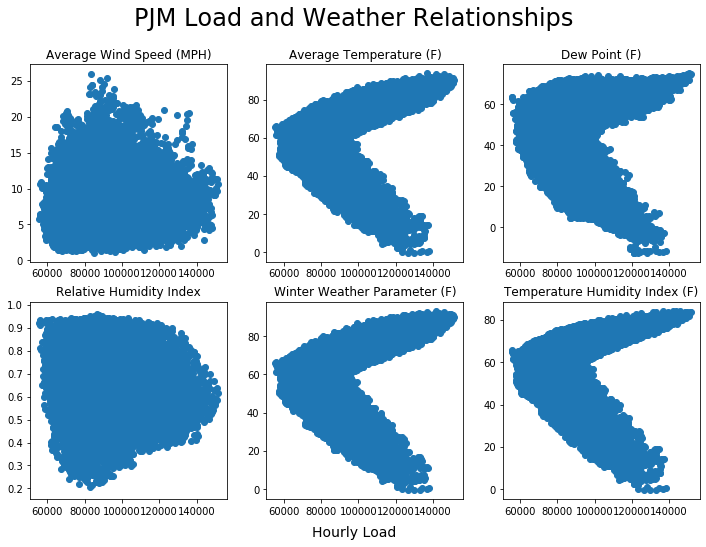

In [279]:
fig = plt.figure(figsize = (12,8))

titles = {
    'WND':'Average Wind Speed (MPH)',
    'TMP':'Average Temperature (F)',
    'DEW':'Dew Point (F)',
    'RH':'Relative Humidity Index',
    'WWP':'Winter Weather Parameter (F)',
    'THI':'Temperature Humidity Index (F)'
}

for i, col in enumerate(['WND','TMP','DEW','RH','WWP','THI']):
    ax = fig.add_subplot(2,3,i+1)
    ax.scatter(df_weather[mask_dates]['RTO_Load'],df_weather[mask_dates][col])
    ax.set_title(titles[col])

plt.suptitle('PJM Load and Weather Relationships', fontsize = 24)

# Common X label from:
# https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots/23638795
fig.text(0.5, 0.06, 'Hourly Load', ha='center', fontsize = 14);

### Peak Load Accuracy

In [280]:
# Import dataset
# df_weather = pd.read_csv('../PJM_Weekly_Model/PJMWeatherData_Hourly_ValidationData.csv', index_col = 0, parse_dates = [0])

In [286]:
# MAPE function taken from:
# https://www.statology.org/mape-python/
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [287]:
# Write model scores to data frame - Meant to include this in loop initially
# Create dataframe for scores
df_scores = pd.DataFrame(index = df_lasso_test.columns[1:])

# Create empty columns for scores
df_scores['lasso_mape'], df_scores['rnn_mape'] = [np.nan,np.nan]

# Loop through each forecast
for column in df_lasso_test.columns[1:]:
    # Slice training and testing dataframes to desired forecast
    df_lasso_calc = df_lasso_test[['value',column]].dropna()
    df_rnn_calc = df_rnn_test[['value',column]].dropna()

    # Calculate MAPE scores for training and testing data
    lasso_mape = round(mape(df_lasso_calc['value'],df_lasso_calc[column]),2)
    rnn_mape = round(mape(df_rnn_calc['value'],df_rnn_calc[column]),2)
    
    # Assign scores
    df_scores.loc[df_scores.index == column,:] = [lasso_mape, rnn_mape]

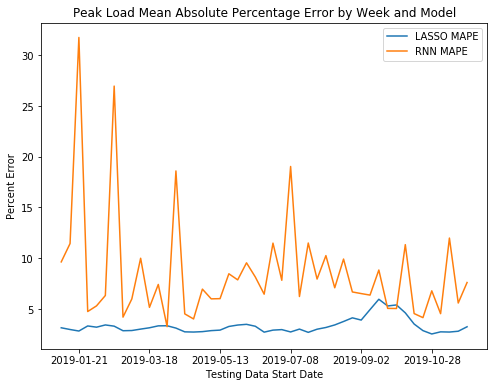

In [289]:
plt.figure(figsize = (8,6))
plt.plot(df_scores[['lasso_mape','rnn_mape']])
plt.xticks(df_scores.index[2::8])
plt.xlabel('Testing Data Start Date')
plt.ylabel('Percent Error')
plt.title('Peak Load Mean Absolute Percentage Error by Week and Model')
plt.legend(labels = ['LASSO MAPE','RNN MAPE']);